# Project 1 Neuronal networks

## 1.- MNIST and FMINST datasets

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [2]:
!pip install wandb
import wandb # Weight & Biases library to monitor training and compare models
wandb.login() # API key: 569de9861dbe18fe8888f13ca66e39d2b12934ff

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

To obtain the MNIST dataset:

In [3]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainsetMNIST = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
train_MNIST = torch.utils.data.DataLoader(trainsetMNIST, batch_size=64, shuffle=True)

# Download and load the test data
testsetMNIST = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
test_MNIST = torch.utils.data.DataLoader(testsetMNIST, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 464543467.39it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 103800937.30it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 159672416.98it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22952444.30it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



To obtain the FMINST dataset:

In [4]:

# Download and load the training data
trainsetFMNIST = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
train_FMNIST = torch.utils.data.DataLoader(trainsetFMNIST, batch_size=64, shuffle=True)

# Download and load the test data
testsetFMNIST = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
test_FMNIST = torch.utils.data.DataLoader(testsetFMNIST, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 9126712.37it/s] 


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 169566.24it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3173760.99it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5688165.70it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [5]:
dataiter = iter(train_MNIST)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
print(torch.min(images), torch.max(images))

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


In [6]:
dataiter = iter(train_FMNIST)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
print(torch.min(images), torch.max(images))

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


We can see that our images are of size 28 x 28 = 784, so the input layer is of size 784. It is important to see that the range of the values are -1,1 so for the output layer we will use the tanh.

We also need to split the training data into training and validation sets.

In [7]:
import copy


valid_MNIST = copy.deepcopy(train_MNIST)  # Creates a copy of the object

#We take the first 45k images for training
train_MNIST.dataset.data = train_MNIST.dataset.data[:45000,:,:]

#And the rest for validation
valid_MNIST.dataset.data = valid_MNIST.dataset.data[45000:,:,:]

valid_FMNIST = copy.deepcopy(train_FMNIST)  # Creates a copy of the object

#We take the first 45k images for training
train_FMNIST.dataset.data = train_FMNIST.dataset.data[:45000,:,:]

#And the rest for validation
valid_FMNIST.dataset.data = valid_FMNIST.dataset.data[45000:,:,:]


## 3 layers at both encoder/decoder:


In [14]:

class autoencoder3(nn.Module):
    def __init__(self, projected_dimension):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001
        self.optim = optim.Adam(self.parameters(), self.learning_rate)
        self.name_train = f"3_layer_with_PSNR_train_dropout{self.projected_dimension}"
        self.name_test = f"3_layer_with_PSNR_test_dropout{self.projected_dimension}"
        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.dataset = "MNIST"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []


        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(self.input_image_size, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2), # Dropout with a probability of 0.2
            nn.Linear(300, 150),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(150, self.projected_dimension),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(self.projected_dimension, 150),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(150, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300, self.input_image_size),
            nn.Tanh(),
        )

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()


        #self.optimizer = optim.SGD(self.parameters(), lr=self.learning_rate)

        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img = img.reshape(-1, self.input_image_size)
                reconstructed = model.forward(img)
                loss_train = self.criterion(reconstructed, img)

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    images = images.reshape(-1, self.input_image_size)

                    out = self.forward(images)

                    loss_valid = self.criterion(out,images)

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": projected_dimensions[run], "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((projected_dimensions[run], epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance

Definition of parameters of the model and Peak signal-to-noise ratio (PSNR)

Training the model

In [16]:
projected_dimensions = [15, 30, 50, 100]
epochs = 15
models = []
for run in range(len(projected_dimensions)):
    model = autoencoder3(projected_dimensions[run])  # To initialize the model with the projected dimension
    model.do_training(epochs,train_MNIST,valid_MNIST)
    models.append(model)

ValueError: optimizer got an empty parameter list

Performance of the model

In [12]:
model.eval_performance(test_MNIST)

tensor(6.1543)

Visualization of reconstructed images

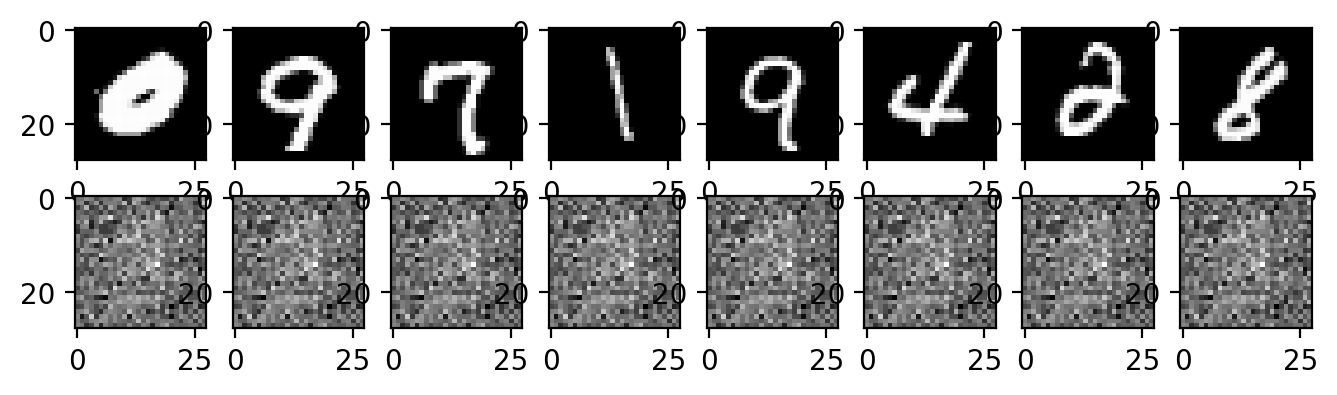

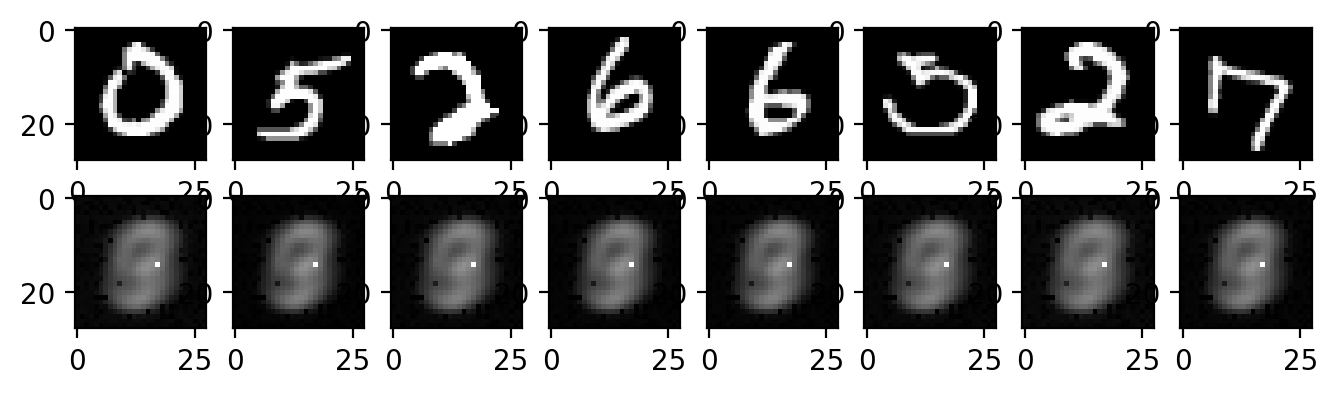

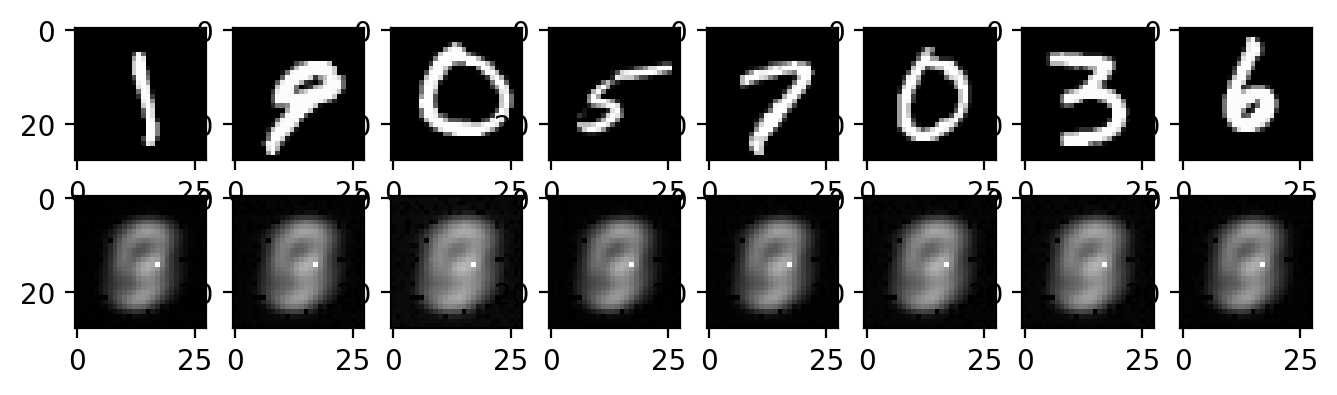

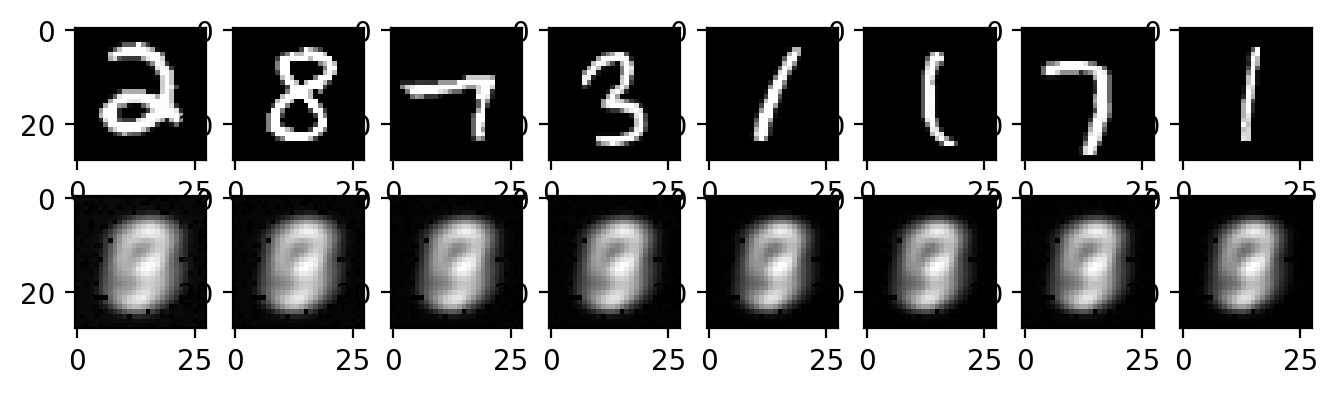

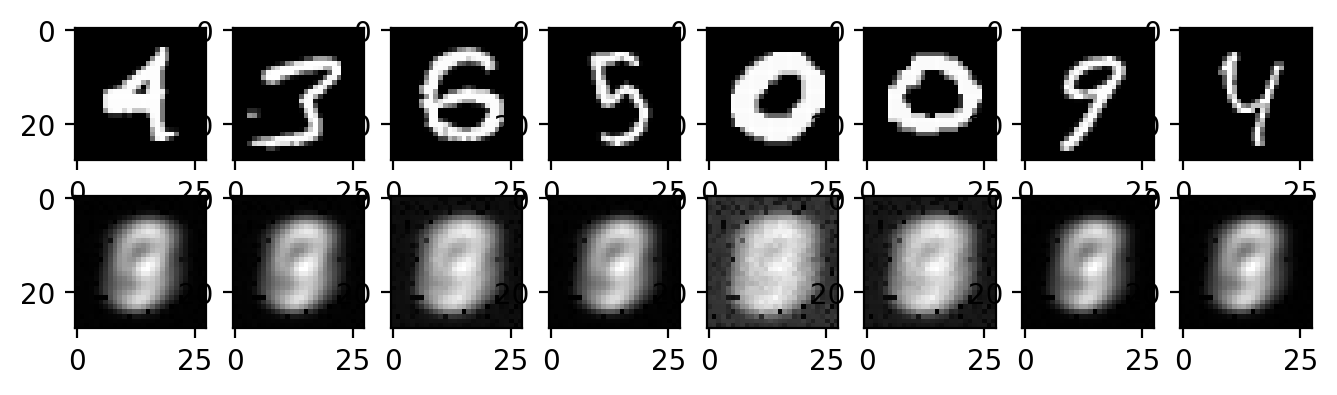

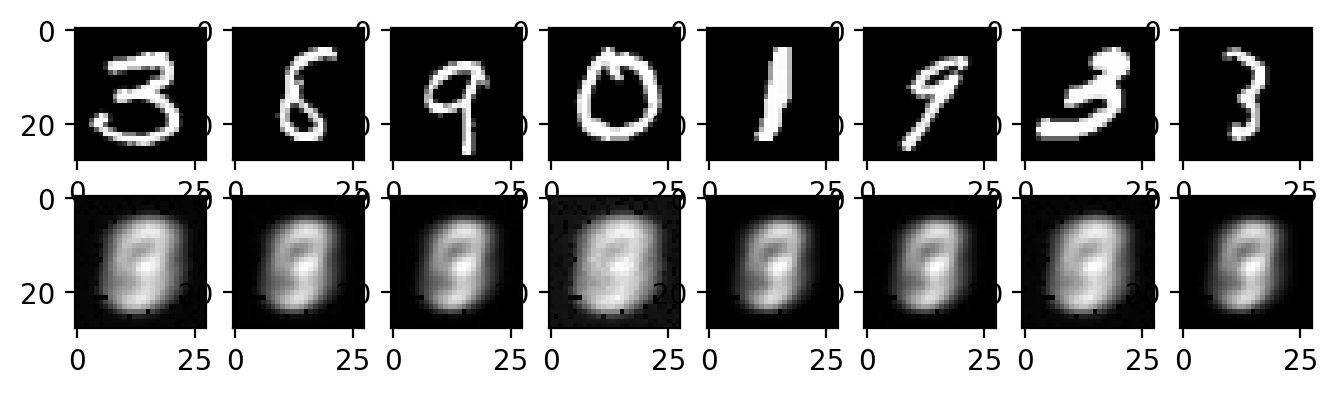

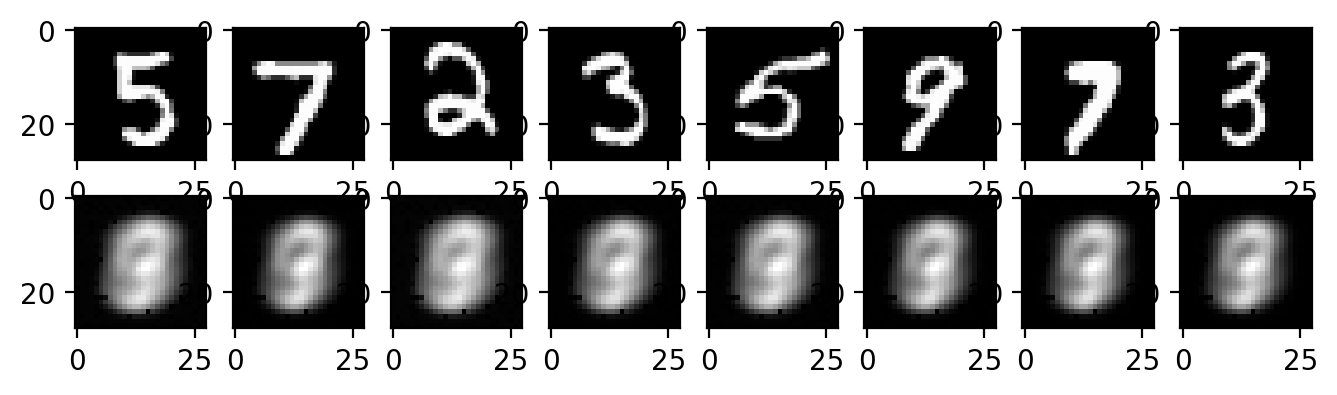

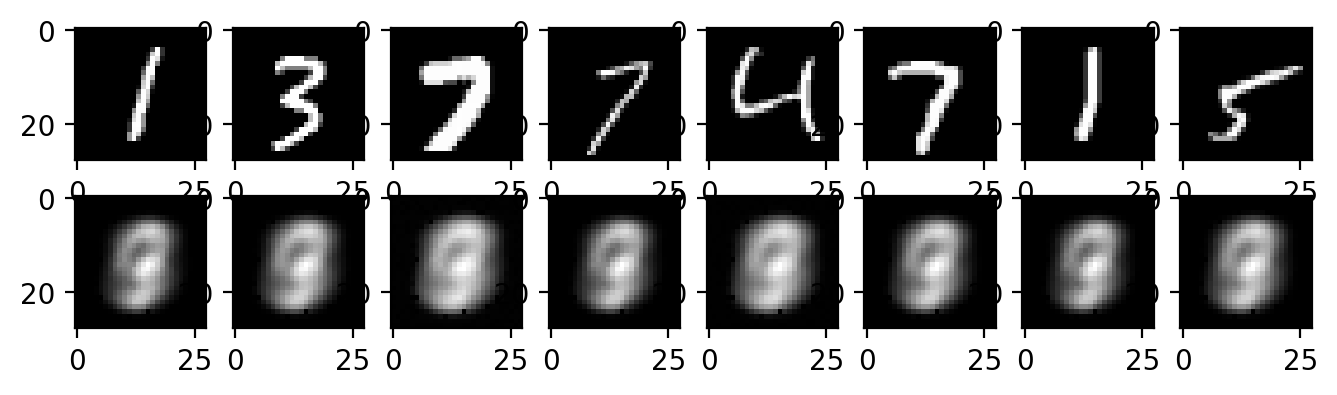

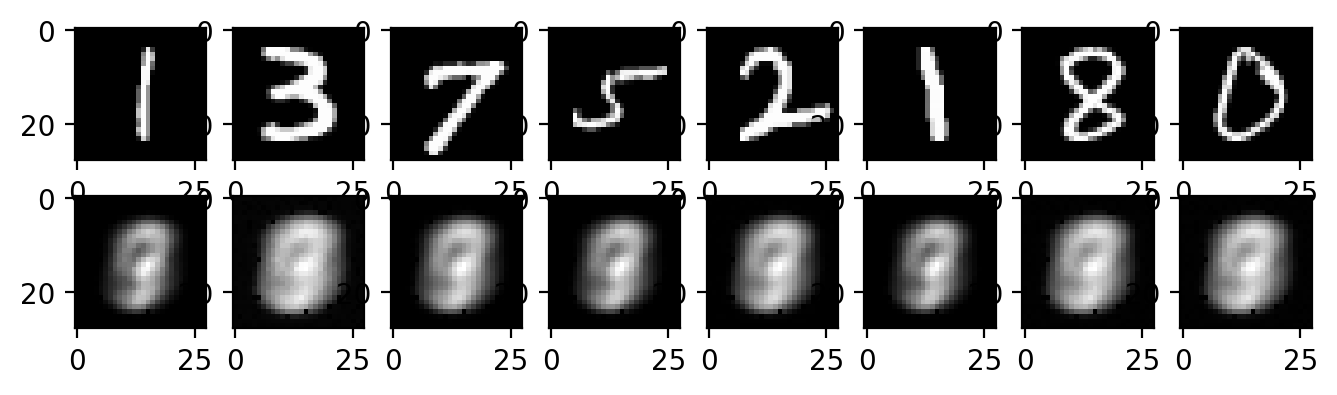

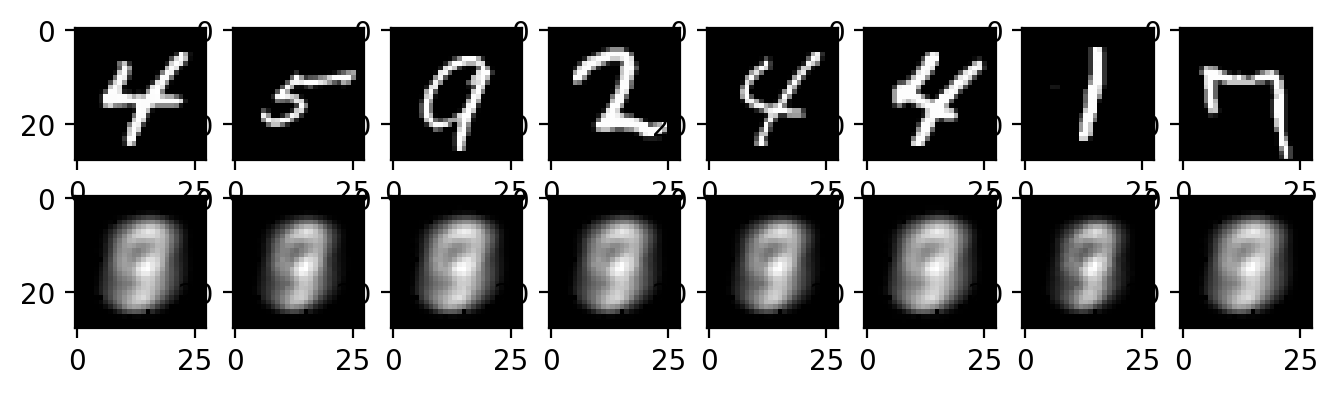

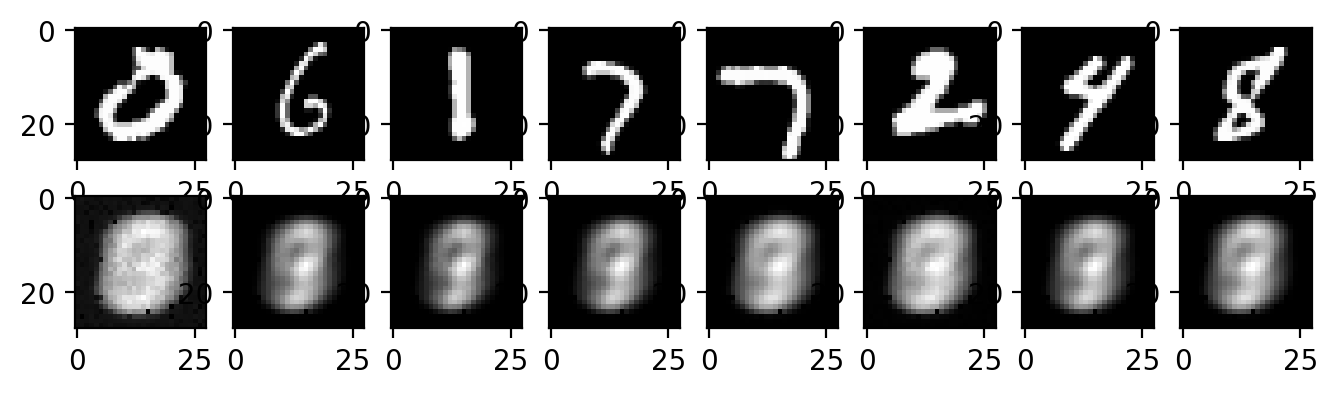

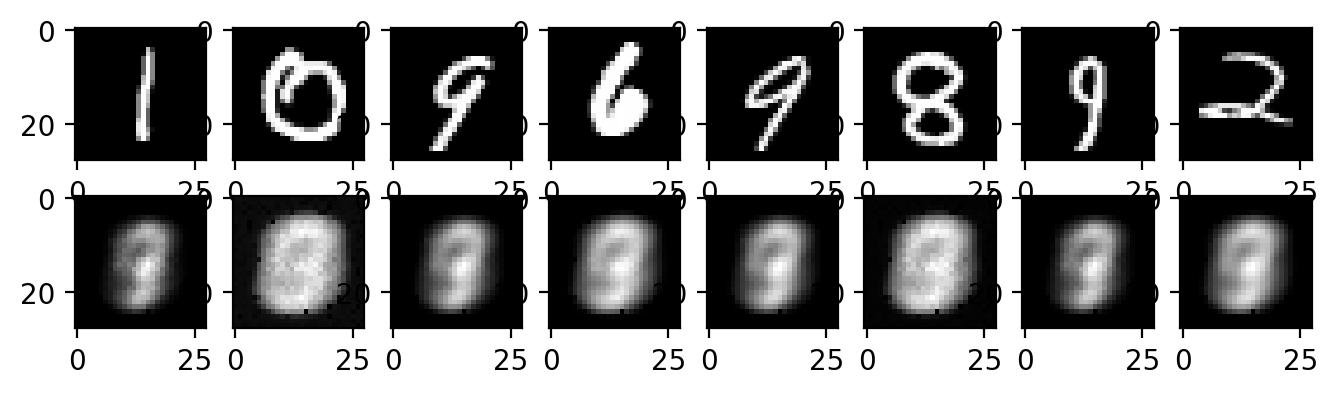

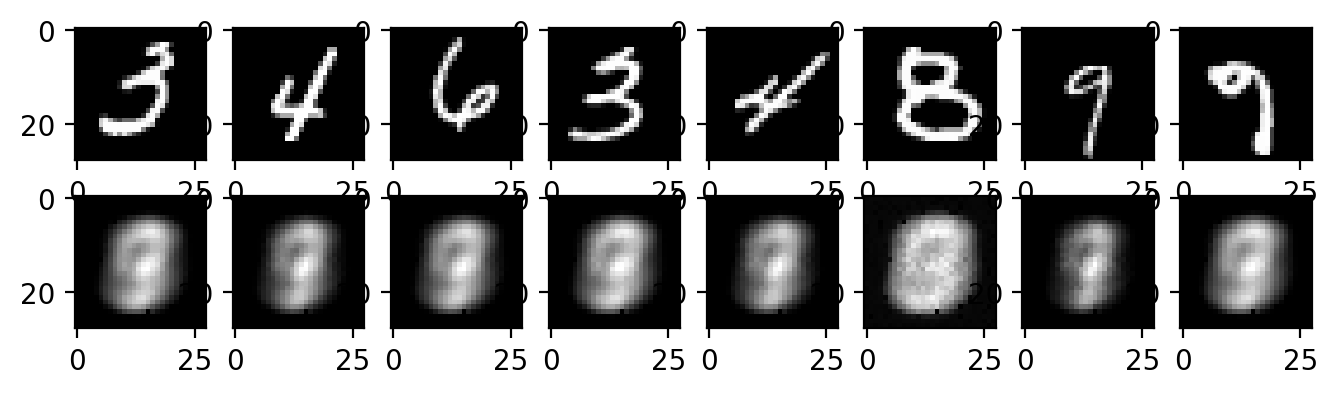

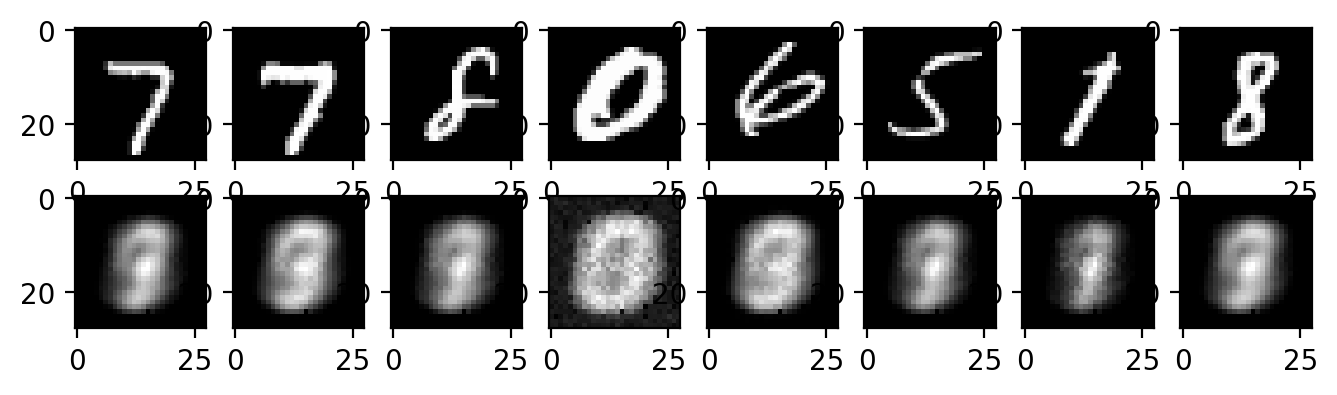

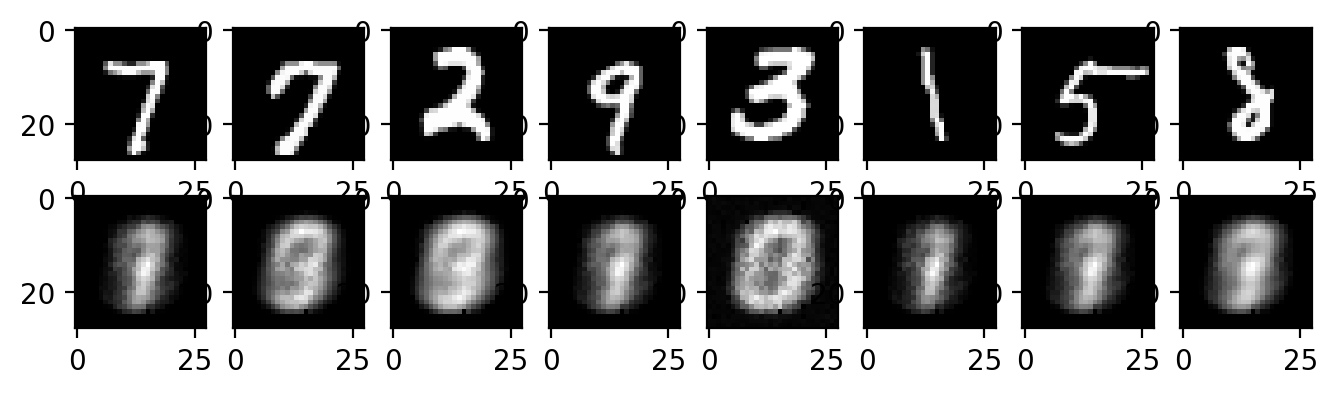

In [13]:
for k in range(0,epochs,2):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs = model.outputs[k][2].detach().numpy()
  recon = model.outputs[k][3].detach().numpy()
  for i, item in enumerate(imgs):
    if i >=9: break
    plt.subplot(2,9,i+1)
    item = item.reshape(-1,28,28)

    plt.imshow(item[0])
  for i, item in enumerate(recon):
    if i >=9: break
    plt.subplot(2,9,i+1+9)
    item = item.reshape(-1,28,28)

    plt.imshow(item[0])



# 5 layers at both encoder/decoder:

In [ ]:
class autoencoder5(nn.Module):
    def __init__(self,projected_dimension):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(784, 550),
            nn.ReLU(),
            nn.Linear(550, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300,200),
            nn.ReLU(),
            nn.Linear(200,projected_dimension)
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(projected_dimension, 200),
            nn.ReLU(),
            nn.Linear(200, 300),
            nn.ReLU(),
            nn.Linear(300, 400),
            nn.ReLU(),
            nn.Linear(400,550),
            nn.ReLU(),
            nn.Linear(550,784),
            nn.Tanh()
        )


    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
total_runs = 4 # To test each of the projected dimensions
for run in range(total_runs):
  model = autoencoder5(projected_dimensions[run]) # To initialize the model with the projected dimension
  optimizer = optim.SGD(model.parameters(), lr = 0.01)
  wandb.init( # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
      # Set the project where this run will be logged
      project="project_1",
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"5_layer_{run}",
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.01,
      "architecture": "linear_autoencoder",
      "dataset": "MNIST",
      "epochs": 10,
      })

    # Aqui es donde empieza realmente el entrenamiento
  epochs = 10
  outputs = []
  for epoch in range(epochs):
    for (img,_) in train_MNIST:
      img = img.reshape(-1,784)
      reconstructed = model.forward(img)
      loss = -psnr(reconstructed,img)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print("Epoch: ", epoch + 1, "Loss: ", loss.item())
    wandb.log({"projected dimension" :projected_dimensions[run], "loss": loss})
    outputs.append((projected_dimensions[run],epoch,img,reconstructed))

  wandb.finish()

# Save the model

In [ ]:
torch.save(model.state_dict(), 'model.pth')